In this notebook, I analyze Google Ads performance data from the last 90 days. The objective is to identify performance patterns across campaigns, search terms, devices, networks, and time. The analysis focuses on understanding what is happening in the data and why certain trends may exist, in order to derive actionable business insights.


# Part 1: Campaign-Level Performance Changes (Biggest Changes)

## Objective
This section analyzes how campaign performance has changed compared to the previous period. The goal is to identify which campaigns improved, declined, or became inefficient, and to understand the possible reasons behind these changes.


In [2]:
import pandas as pd 
import numpy as np 
biggest_changes = pd.read_csv(r'C:\Users\Ayushi\Desktop\Google-ads-analysis\Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02).csv.csv')

In [3]:
biggest_changes.head()

,Campaign Name,Cost,Cost (Comparison),Clicks,Clicks (Comparison),Interactions,Interactions (Comparison)
0,Power Supply all,"₹24,532.22","₹7,139.77","2,969","1,068","95,939","38,566"
1,Component Testing- Targeted States,"₹16,475.57","₹1,437.68","1,955",336,"2,051",382
2,Hantek,"₹14,363.98","₹1,830.89","1,423",306,"1,709",533
3,YIHUA,"₹9,407.04",₹0.00,"3,158",0,"4,278",0
4,UNI-T,"₹9,855.77",₹459.41,"2,164",256,"2,164",256


In [4]:
biggest_changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Campaign Name              22 non-null     object
 1   Cost                       22 non-null     object
 2   Cost (Comparison)          22 non-null     object
 3   Clicks                     22 non-null     object
 4   Clicks (Comparison)        22 non-null     object
 5   Interactions               22 non-null     object
 6   Interactions (Comparison)  22 non-null     object
dtypes: object(7)
memory usage: 1.3+ KB


In [5]:
cols_to_clean = ['Cost','Cost (Comparison)','Clicks','Clicks (Comparison)','Interactions','Interactions (Comparison)']

for col in cols_to_clean:
  biggest_changes[col] = (biggest_changes[col]
                          .str.replace("₹","",regex=False) 
                          .str.replace(",","",regex=False)
                          .astype(float)
  )
  

In [7]:
biggest_changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Campaign Name              22 non-null     object 
 1   Cost                       22 non-null     float64
 2   Cost (Comparison)          22 non-null     float64
 3   Clicks                     22 non-null     float64
 4   Clicks (Comparison)        22 non-null     float64
 5   Interactions               22 non-null     float64
 6   Interactions (Comparison)  22 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.3+ KB


Initially, all performance metrics such as cost, clicks, and interactions were stored as text values due to currency symbols and formatting. These columns were cleaned by removing symbols and converting them into numeric data types to enable mathematical operations and analysis.

In [9]:
biggest_changes.columns

Index(['Campaign Name', 'Cost', 'Cost (Comparison)', 'Clicks',
       'Clicks (Comparison)', 'Interactions', 'Interactions (Comparison)'],
      dtype='object')

In [16]:
biggest_changes = biggest_changes.rename(columns={
    "Campaign Name": "campaign",
    "Cost": "cost_current",
    "Cost (Comparison)": "cost_previous",
    "Clicks": "clicks_current",
    "Clicks (Comparison)": "clicks_previous",
    "Interactions": "interactions_current",
    "Interactions (Comparison)": "interactions_previous"
})


In [17]:
#handle missing values

biggest_changes.isnull().sum()

campaign                 0
cost_current             0
cost_previous            0
clicks_current           0
clicks_previous          0
interactions_current     0
interactions_previous    0
dtype: int64

The dataset is complete with no missing values. All campaigns have valid data for both current and comparison periods.

In [18]:
numeric_cols = [
    "cost_current", "cost_previous",
    "clicks_current", "clicks_previous",
    "interactions_current", "interactions_previous"
]


In [19]:
(biggest_changes[numeric_cols] < 0).sum()


cost_current             0
cost_previous            0
clicks_current           0
clicks_previous          0
interactions_current     0
interactions_previous    0
dtype: int64

In [20]:
#feature engineering
biggest_changes["click_change"] = (
    biggest_changes["clicks_current"] - biggest_changes["clicks_previous"]
)

biggest_changes["cost_change"] = (
    biggest_changes["cost_current"] - biggest_changes["cost_previous"]
)

biggest_changes["interaction_change"] = (
    biggest_changes["interactions_current"] - biggest_changes["interactions_previous"]
)


In [21]:
biggest_changes["click_pct_change"] = np.where(
    biggest_changes["clicks_previous"] == 0,
    np.nan,
    biggest_changes["click_change"] / biggest_changes["clicks_previous"]
)

biggest_changes["cost_pct_change"] = np.where(
    biggest_changes["cost_previous"] == 0,
    np.nan,
    biggest_changes["cost_change"] / biggest_changes["cost_previous"]
)


In [22]:
def classify_campaign(row):
    if row["clicks_previous"] == 0 and row["clicks_current"] > 0:
        return "New Campaign"
    elif row["click_change"] > 0:
        return "Improved Campaign"
    elif row["click_change"] < 0:
        return "Declined Campaign"
    else:
        return "No Change"

biggest_changes["campaign_status"] = biggest_changes.apply(classify_campaign, axis=1)


In [23]:
biggest_changes.head()

,campaign,cost_current,cost_previous,clicks_current,clicks_previous,interactions_current,interactions_previous,click_change,cost_change,interaction_change,click_pct_change,cost_pct_change,campaign_status
0,Power Supply all,24532.22,7139.77,2969.0,1068.0,95939.0,38566.0,1901.0,17392.45,57373.0,1.779963,2.435996,Improved Campaign
1,Component Testing- Targeted States,16475.57,1437.68,1955.0,336.0,2051.0,382.0,1619.0,15037.89,1669.0,4.818452,10.459831,Improved Campaign
2,Hantek,14363.98,1830.89,1423.0,306.0,1709.0,533.0,1117.0,12533.09,1176.0,3.650327,6.845354,Improved Campaign
3,YIHUA,9407.04,0.00,3158.0,0.0,4278.0,0.0,3158.0,9407.04,4278.0,NaN,NaN,New Campaign
4,UNI-T,9855.77,459.41,2164.0,256.0,2164.0,256.0,1908.0,9396.36,1908.0,7.453125,20.453103,Improved Campaign


In [24]:
#top improved campaigns
biggest_changes.sort_values("click_change", ascending=False).head(5)


,campaign,cost_current,cost_previous,clicks_current,clicks_previous,interactions_current,interactions_previous,click_change,cost_change,interaction_change,click_pct_change,cost_pct_change,campaign_status
6,Multimeters- Targeted States,6226.86,691.26,3588.0,381.0,3826.0,502.0,3207.0,5535.60,3324.0,8.417323,8.007985,Improved Campaign
3,YIHUA,9407.04,0.00,3158.0,0.0,4278.0,0.0,3158.0,9407.04,4278.0,NaN,NaN,New Campaign
7,Target All- All Products,4674.64,545.36,2808.0,293.0,2839.0,423.0,2515.0,4129.28,2416.0,8.583618,7.571659,Improved Campaign
8,Soldering Station- Targeted States,7415.28,3818.86,3719.0,1411.0,3950.0,3751.0,2308.0,3596.42,199.0,1.635719,0.941752,Improved Campaign
4,UNI-T,9855.77,459.41,2164.0,256.0,2164.0,256.0,1908.0,9396.36,1908.0,7.453125,20.453103,Improved Campaign


In [25]:
#biggest declines
biggest_changes.sort_values("click_change").head(5)


,campaign,cost_current,cost_previous,clicks_current,clicks_previous,interactions_current,interactions_previous,click_change,cost_change,interaction_change,click_pct_change,cost_pct_change,campaign_status
15,Soldering Station new,0.00,2125.00,0.0,4115.0,0.0,4178.0,-4115.0,-2125.00,-4178.0,-1.000000,-1.000000,Declined Campaign
16,Clamp Meter- Targeted States,422.46,2351.67,376.0,4408.0,377.0,4626.0,-4032.0,-1929.21,-4249.0,-0.914701,-0.820357,Declined Campaign
19,Oscilloscope PA - 3/FEB/24 Ravi,0.00,1415.60,0.0,242.0,0.0,351.0,-242.0,-1415.60,-351.0,-1.000000,-1.000000,Declined Campaign
18,Power Supply PA - 8/FEB/24 Ravi,0.00,1583.14,0.0,217.0,0.0,270.0,-217.0,-1583.14,-270.0,-1.000000,-1.000000,Declined Campaign
20,Targeted states- Multimeter,210.69,1531.02,32.0,204.0,32.0,449.0,-172.0,-1320.33,-417.0,-0.843137,-0.862386,Declined Campaign


In [26]:
#new campaigns
biggest_changes[biggest_changes["campaign_status"] == "New Campaign"]


,campaign,cost_current,cost_previous,clicks_current,clicks_previous,interactions_current,interactions_previous,click_change,cost_change,interaction_change,click_pct_change,cost_pct_change,campaign_status
3,YIHUA,9407.04,0.0,3158.0,0.0,4278.0,0.0,3158.0,9407.04,4278.0,NaN,NaN,New Campaign
9,UNI-T Instruments,3553.51,0.0,941.0,0.0,7156.0,0.0,941.0,3553.51,7156.0,NaN,NaN,New Campaign
10,Rishabh,3131.06,0.0,863.0,0.0,885.0,0.0,863.0,3131.06,885.0,NaN,NaN,New Campaign
13,Temperature Meter,2922.79,0.0,157.0,0.0,16564.0,0.0,157.0,2922.79,16564.0,NaN,NaN,New Campaign
17,Shield Plus,1842.29,0.0,450.0,0.0,462.0,0.0,450.0,1842.29,462.0,NaN,NaN,New Campaign
21,Ingersoll Rand,1132.14,0.0,115.0,0.0,128.0,0.0,115.0,1132.14,128.0,NaN,NaN,New Campaign


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

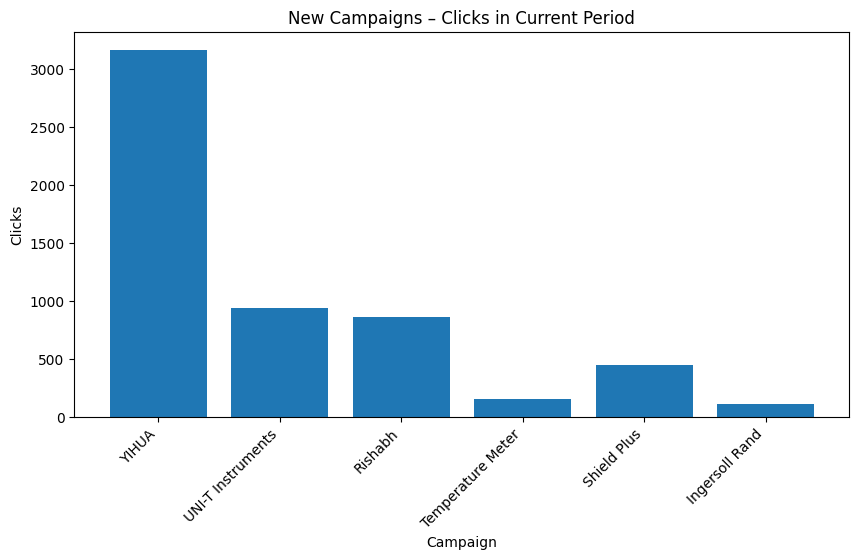

In [29]:
new_campaigns = biggest_changes[biggest_changes["campaign_status"] == "New Campaign"]

plt.figure(figsize=(10,5))
plt.bar(new_campaigns["campaign"], new_campaigns["clicks_current"])
plt.xticks(rotation=45, ha="right")
plt.title("New Campaigns – Clicks in Current Period")
plt.ylabel("Clicks")
plt.xlabel("Campaign")
plt.show()


In [ ]:
Campaigns with zero clicks in the previous period but noticeable clicks in the current period indicate newly launched campaigns. These campaigns are starting to gain user attention.

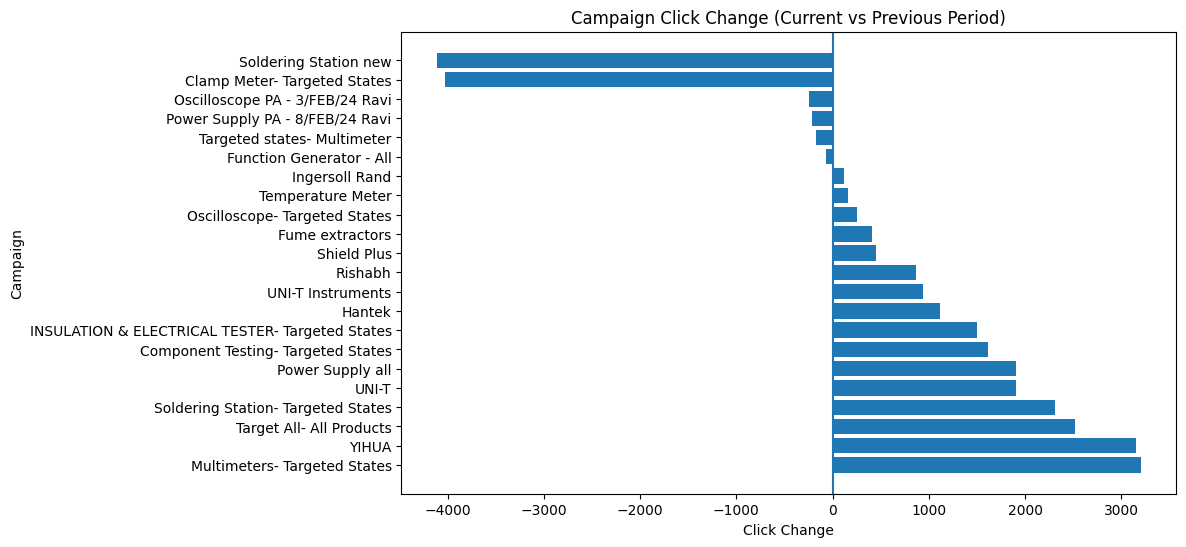

In [ ]:
#improved vs declined campaign
top_changes = biggest_changes.sort_values("click_change", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(top_changes["campaign"], top_changes["click_change"])
plt.axvline(0)  # zero reference line
plt.title("Campaign Click Change (Current vs Previous Period)")
plt.xlabel("Click Change")
plt.ylabel("Campaign")
plt.show()


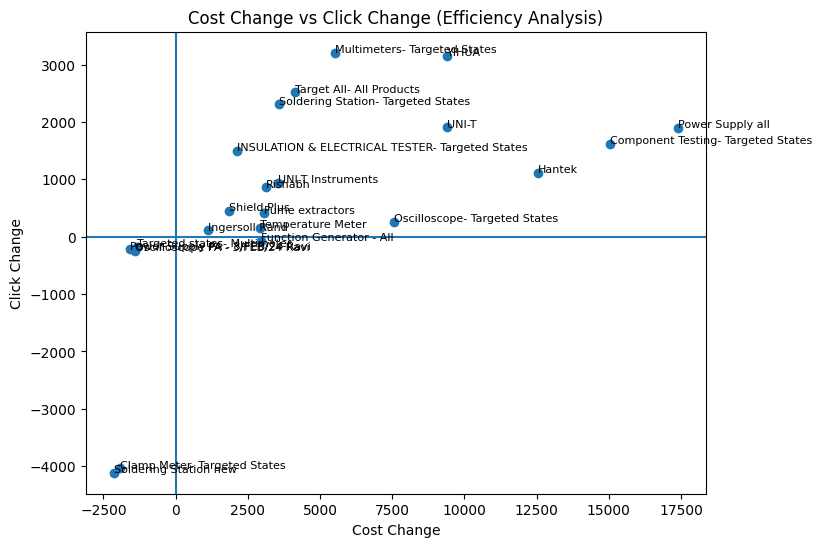

In [31]:
#Inefficiency
#Cost increase without click growth indicates inefficiency.

plt.figure(figsize=(8,6))
plt.scatter(
    biggest_changes["cost_change"],
    biggest_changes["click_change"]
)

plt.axhline(0)
plt.axvline(0)

plt.xlabel("Cost Change")
plt.ylabel("Click Change")
plt.title("Cost Change vs Click Change (Efficiency Analysis)")

for i, txt in enumerate(biggest_changes["campaign"]):
    plt.annotate(txt, 
                 (biggest_changes["cost_change"].iloc[i],
                  biggest_changes["click_change"].iloc[i]),
                 fontsize=8)

plt.show()


In [33]:
biggest_changes.columns

Index(['campaign', 'cost_current', 'cost_previous', 'clicks_current',
       'clicks_previous', 'interactions_current', 'interactions_previous',
       'click_change', 'cost_change', 'interaction_change', 'click_pct_change',
       'cost_pct_change', 'campaign_status'],
      dtype='object')

In [34]:
def efficiency_label(row):
    if row["cost_change"] > 0 and row["click_change"] <= 0:
        return "Inefficient (Cost ↑, Clicks ↓)"
    elif row["cost_change"] > 0 and row["click_change"] > 0:
        return "Scaled Well"
    elif row["cost_change"] <= 0 and row["click_change"] > 0:
        return "Efficient (Cost ↓, Clicks ↑)"
    else:
        return "Declined"

biggest_changes["efficiency"] = biggest_changes.apply(efficiency_label, axis=1)


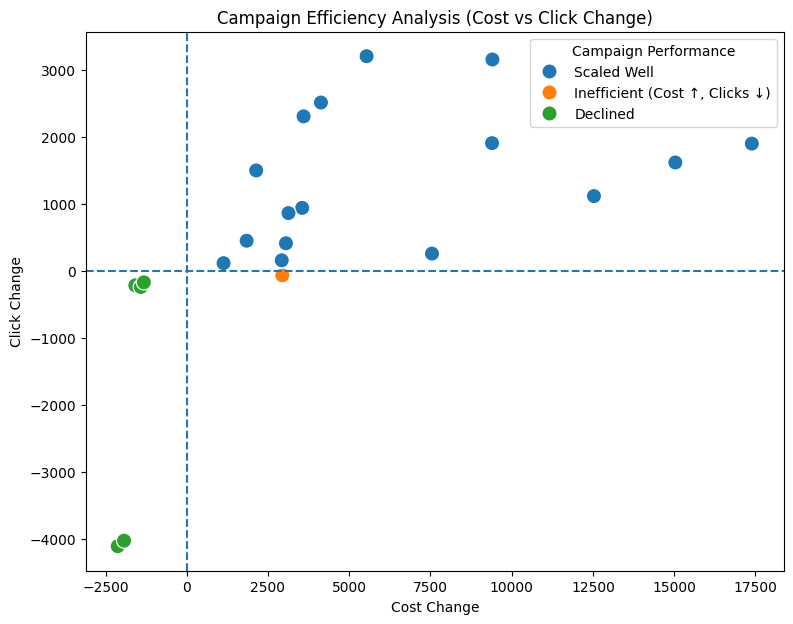

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))

sns.scatterplot(
    data=biggest_changes,
    x="cost_change",
    y="click_change",
    hue="efficiency",
    s=120
)

plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")

plt.xlabel("Cost Change")
plt.ylabel("Click Change")
plt.title("Campaign Efficiency Analysis (Cost vs Click Change)")

plt.legend(title="Campaign Performance")
plt.show()


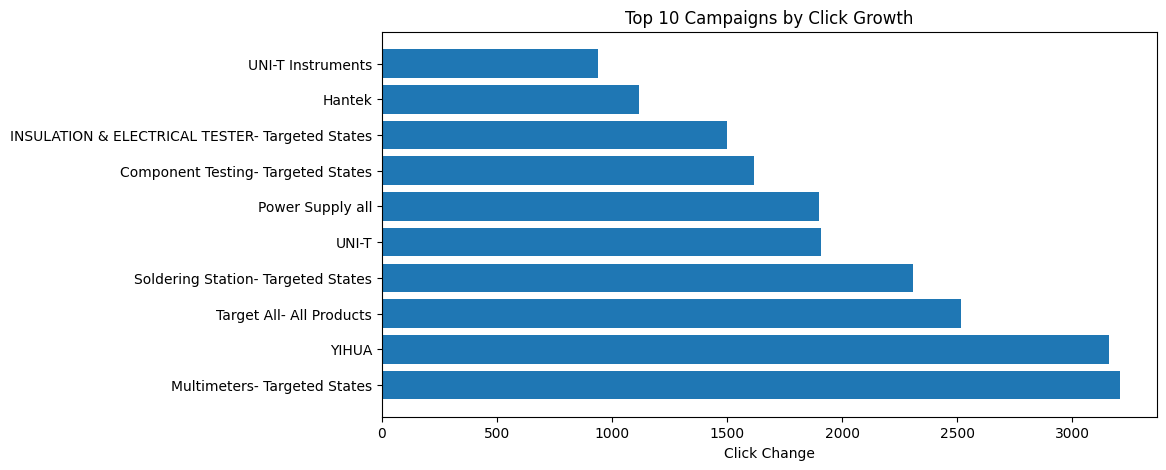

In [36]:
import matplotlib.pyplot as plt

top_growth = biggest_changes.sort_values("click_change", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top_growth["campaign"], top_growth["click_change"])
plt.title("Top 10 Campaigns by Click Growth")
plt.xlabel("Click Change")
plt.show()


In [37]:
best_campaign = biggest_changes.sort_values(
    "click_change", ascending=False
).iloc[0]

best_campaign[["campaign", "click_change", "cost_change"]]


campaign        Multimeters- Targeted States
click_change                          3207.0
cost_change                           5535.6
Name: 6, dtype: object

In [38]:
worst_campaign = biggest_changes[
    (biggest_changes["cost_change"] > 0) &
    (biggest_changes["click_change"] <= 0)
].sort_values("cost_change", ascending=False).iloc[0]

worst_campaign[["campaign", "click_change", "cost_change"]]


campaign        Function Generator - All
click_change                       -67.0
cost_change                      2941.63
Name: 12, dtype: object

In [40]:
def campaign_category(row):
    if row["click_change"] == biggest_changes["click_change"].max():
        return "Best Campaign"
    elif row["cost_change"] > 0 and row["click_change"] <= 0:
        return "Worst / Inefficient Campaign"
    elif row["click_change"] < 0:
        return "Declined Campaign"
    else:
        return "Average / Stable Campaign"

biggest_changes["category"] = biggest_changes.apply(campaign_category, axis=1)


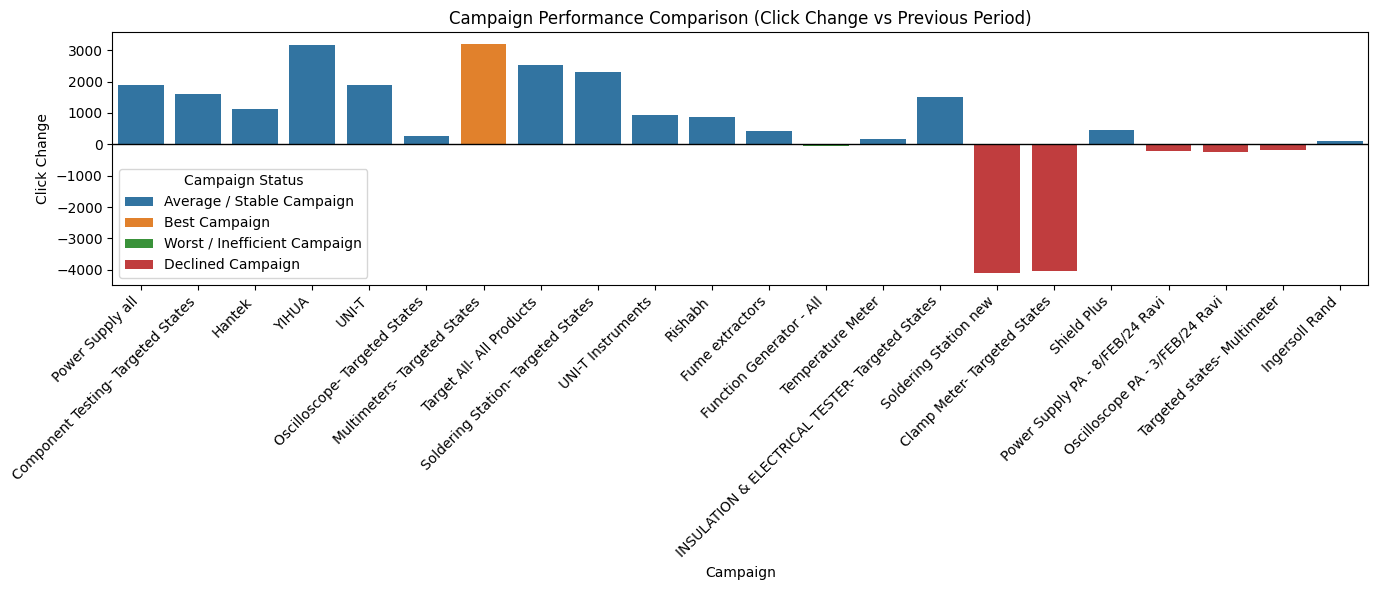

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

sns.barplot(
    data=biggest_changes,
    x="campaign",
    y="click_change",
    hue="category"
)

plt.axhline(0, color="black", linewidth=1)

plt.title("Campaign Performance Comparison (Click Change vs Previous Period)")
plt.xlabel("Campaign")
plt.ylabel("Click Change")

plt.xticks(rotation=45, ha="right")
plt.legend(title="Campaign Status")

plt.tight_layout()
plt.show()


As we can see from the graph that the best campaign is multimeter-targeted-states and the declined campaigns can also be seen from the graph in RED color.now lets move to the other tabs for analysis and find out what is the reason behind some campaign declined or some considered best.

## Key Insights
- Some campaigns show significant click growth, indicating improved engagement or strategic scaling.
- Certain campaigns experienced cost increases without corresponding click growth, suggesting inefficiency.
- Declined campaigns are often associated with reduced activity rather than poor ad relevance.

## Business Interpretation
Campaign performance changes are driven more by how campaigns are managed (budget allocation, activation) than by sudden changes in user interest.


##sheet -2 TIME SERIES ANALYSIS

What this sheet helps answer:

1.Are campaigns improving or declining over time?

2.When do performance spikes or drops happen?

3.Are there inactive days?

4.How do clicks, impressions, CTR, and CPC behave together?

# Part 2: Time Series Analysis (Daily Performance)

## Objective
The purpose of this section is to analyze daily trends in clicks, impressions, CTR, and CPC to understand when performance changes occurred and how consistently campaigns were running over time.


In [43]:
#LOAD THE DATA

time_series = pd.read_csv(
    r"C:\Users\Ayushi\Desktop\Google-ads-analysis\Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Time_series(2025.11.03-2026.02.03).csv.csv"
)


In [44]:
time_series.head()

,Date,Clicks,Impressions,CTR,Avg. CPC
0,"Mon, 3 Nov 2025",702,"18,643",3.77%,₹2.07
1,"Tue, 4 Nov 2025",576,"18,721",3.08%,₹2.77
2,"Wed, 5 Nov 2025",816,"37,940",2.15%,₹2.94
3,"Thu, 6 Nov 2025",961,"41,471",2.32%,₹2.79
4,"Fri, 7 Nov 2025","1,110","43,428",2.56%,₹2.62


In [45]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         93 non-null     object
 1   Clicks       93 non-null     object
 2   Impressions  93 non-null     object
 3   CTR          93 non-null     object
 4   Avg. CPC     93 non-null     object
dtypes: object(5)
memory usage: 3.8+ KB


In [46]:
time_series["Date"] = pd.to_datetime(time_series["Date"])


In [47]:
cols = ["Clicks", "Impressions", "CTR", "Avg. CPC"]

for col in cols:
    time_series[col] = (
        time_series[col]
        .astype(str)
        .str.replace("%", "", regex=False)
        .str.replace("₹", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )


In [48]:
time_series.head()

,Date,Clicks,Impressions,CTR,Avg. CPC
0,2025-11-03,702.0,18643.0,3.77,2.07
1,2025-11-04,576.0,18721.0,3.08,2.77
2,2025-11-05,816.0,37940.0,2.15,2.94
3,2025-11-06,961.0,41471.0,2.32,2.79
4,2025-11-07,1110.0,43428.0,2.56,2.62


In [49]:
time_series.isnull().sum()


Date           0
Clicks         0
Impressions    0
CTR            0
Avg. CPC       0
dtype: int64

In [50]:
time_series.describe()

,Date,Clicks,Impressions,CTR,Avg. CPC
count,93,93.000000,93.000000,93.000000,93.000000
mean,2025-12-19 00:00:00,358.827957,12841.645161,2.051398,2.896559
min,2025-11-03 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2025-11-26 00:00:00,0.000000,0.000000,0.000000,0.000000
50%,2025-12-19 00:00:00,332.000000,10601.000000,2.600000,3.570000
75%,2026-01-11 00:00:00,576.000000,20853.000000,3.180000,4.510000
max,2026-02-03 00:00:00,1964.000000,67835.000000,5.560000,7.950000
std,NaN,370.618714,13673.408914,1.519586,2.321923


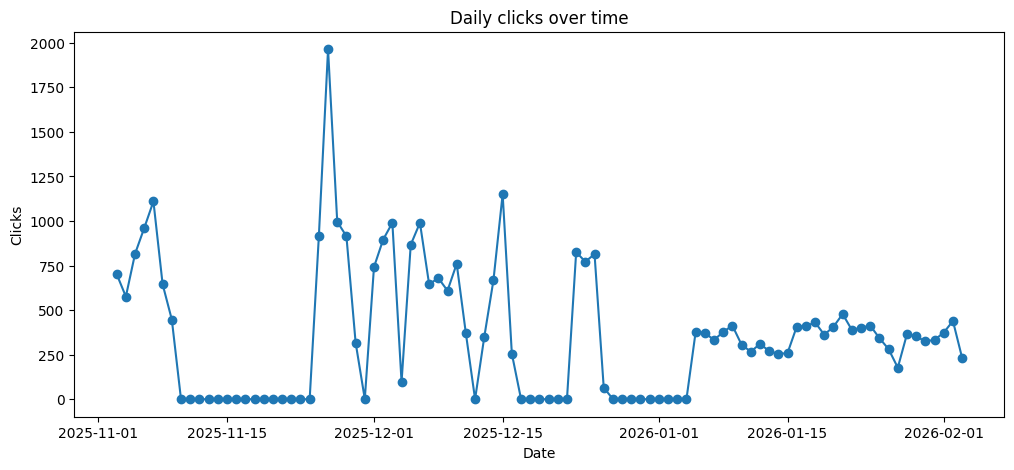

In [54]:
plt.figure(figsize=(12,5))
plt.plot(time_series['Date'],time_series['Clicks'],marker='o')
plt.title('Daily clicks over time')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.show()

Click activity goes through clear ups and downs over time. Early November shows strong engagement when campaigns were actively running, followed by long gaps where ads were paused or budgets ran out.
Toward the end of November and early December, clicks spike sharply, suggesting campaigns were restarted or scaled up aggressively.
Mid-December looks inconsistent, with ads switching on and off, while January becomes more stable but at a lower level of activity.
Overall, the changes in performance are mainly due to how consistently the campaigns were run, rather than a lack of user interest.

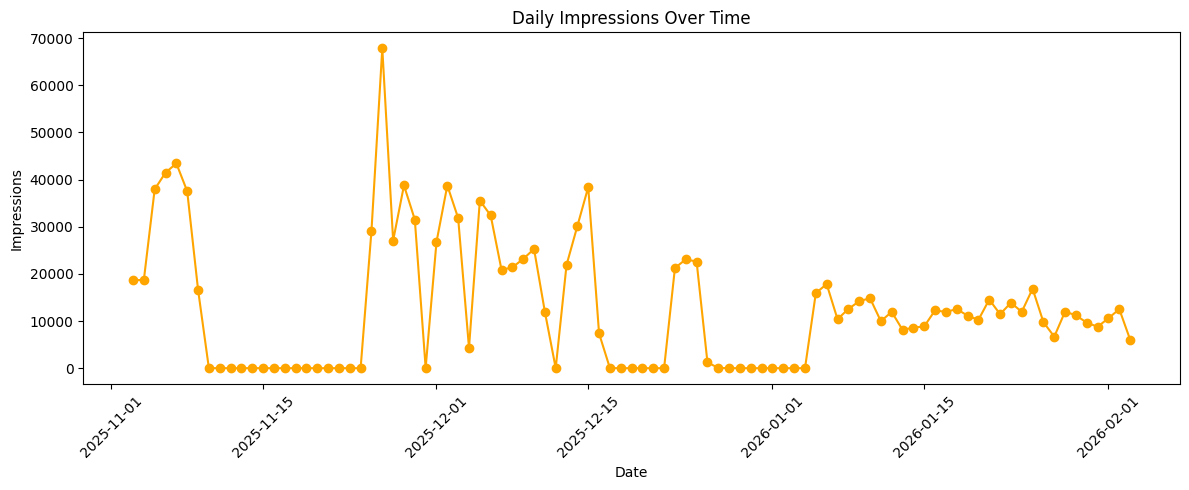

In [56]:
##IMPRESSIONS TREND 
plt.figure(figsize=(12,5))
plt.plot(time_series["Date"], time_series["Impressions"], color="orange",marker='o')

plt.title("Daily Impressions Over Time")
plt.xlabel("Date")
plt.ylabel("Impressions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
BOTH IMPRESSIONS AND CLICKS HAVE LITTLE BIT SIMILAR GRAPHS

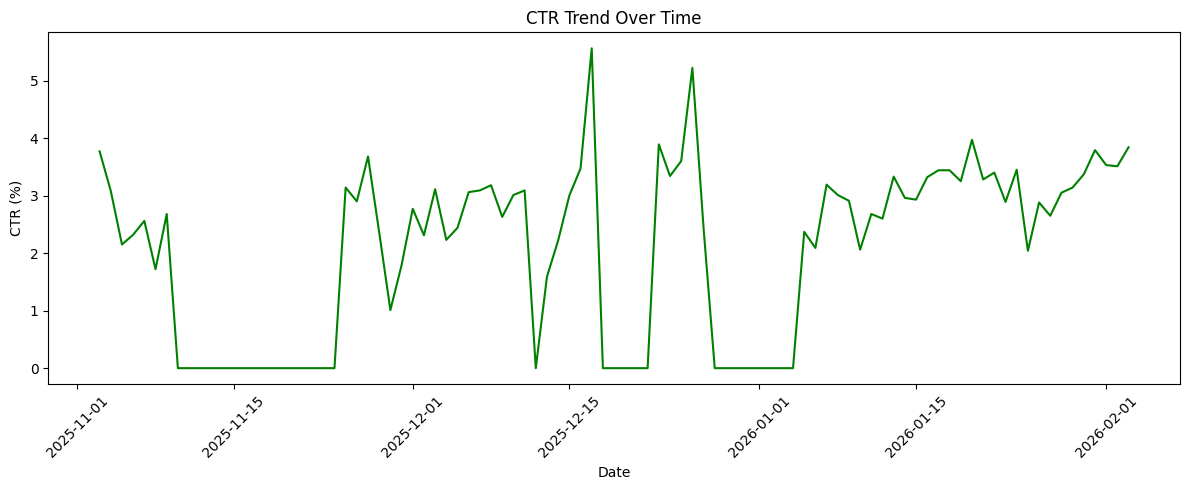

In [57]:
plt.figure(figsize=(12,5))
plt.plot(time_series["Date"], time_series["CTR"], color="green")

plt.title("CTR Trend Over Time")
plt.xlabel("Date")
plt.ylabel("CTR (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


CTR varies across days, indicating changing ad relevance or audience intent. Sudden drops in CTR may signal ad fatigue or poor keyword matching.

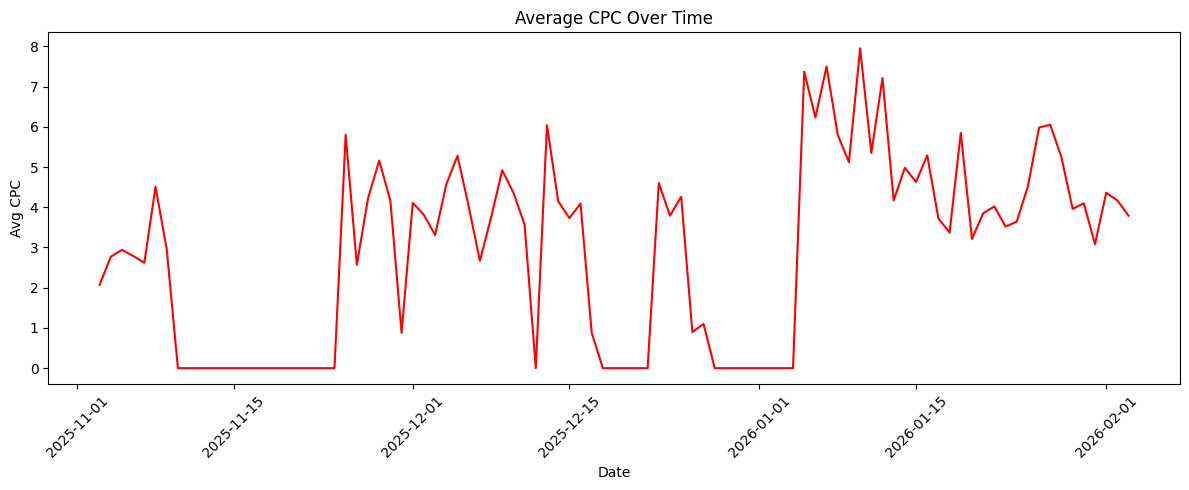

In [58]:
#VISUALIZATION OF CPC
plt.figure(figsize=(12,5))
plt.plot(time_series["Date"], time_series["Avg. CPC"], color="red")

plt.title("Average CPC Over Time")
plt.xlabel("Date")
plt.ylabel("Avg CPC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



CPC rises steeply and reaches its highest values (₹7–₹8) in 2026.
CPC rises sharply during late November–early December and early January, indicating increased competition and aggressive bidding, while early November and mid-to-late January show more stable CPC levels, reflecting controlled bidding strategies.

In [59]:
#INACTIVE DAYS
inactive_days = time_series[
    (time_series["Clicks"] == 0) &
    (time_series["Impressions"] == 0)
]

inactive_days[["Date"]]


,Date
7,2025-11-10
9,2025-11-12
10,2025-11-13
13,2025-11-16
14,2025-11-17
15,2025-11-18
16,2025-11-19
17,2025-11-20
18,2025-11-21
19,2025-11-22


In [60]:
time_series[["Clicks", "Impressions", "CTR", "Avg. CPC"]].corr()


,Clicks,Impressions,CTR,Avg. CPC
Clicks,1.000000,0.956004,0.568552,0.518869
Impressions,0.956004,1.000000,0.464622,0.526137
CTR,0.568552,0.464622,1.000000,0.695137
Avg. CPC,0.518869,0.526137,0.695137,1.000000


Avg. CPC TO Clicks (Weak or Inconsistent Correlation) - Paying more per click doesn’t guarantee more clicks.

Impressions TO CTR (Low / Slight Correlation) - Increasing reach alone won’t improve engagement unless relevance stays high.

Clicks TO CTR (Moderate Positive Correlation) - Higher CTR usually leads to more clicks, but impressions still matter.

Clicks TO Impressions (Strong Positive Correlation) - When impressions increase, clicks also increase.

## Key Insights
- Performance is highly uneven, with multiple days showing zero activity.
- When campaigns are active, click volume and CTR remain healthy.
- CPC fluctuates significantly, indicating changes in competition and bidding pressure.

## Business Interpretation
The primary performance constraint is inconsistent campaign activation and budget pacing rather than ad quality.


# Part 3: Search Terms Analysis (User Intent)

## Objective
This section analyzes actual search queries used by users to understand intent quality, identify high-performing searches, and detect wasted spend caused by irrelevant or low-intent queries.


In [61]:
#analysis of search data
search = pd.read_csv(r'C:\Users\Ayushi\Desktop\Google-ads-analysis\Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Searches(Word_2025.11.03-2026.02.03).csv')

In [62]:
search.head()

,Word,Cost,Clicks,Impressions,Conversions,Top Containing Queries
0,t,₹410.48,159,"6,192",0,"(uni t multimeter, uni t clamp meter, uni t)"
1,multimeter,₹177.08,110,"6,028",0,"(uni t multimeter, multimeter, unit multimeter)"
2,uni t,₹402.71,150,"5,777",0,"(uni t multimeter, uni t clamp meter, uni t)"
3,meter,₹247.37,62,"4,256",0,"(lcr meter, uni t clamp meter, clamp meter)"
4,thermal,₹225.34,20,"3,207",0,"(thermal camera, thermal imaging camera, therm..."


In [63]:
search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Word                    83 non-null     object
 1   Cost                    83 non-null     object
 2   Clicks                  83 non-null     int64 
 3   Impressions             83 non-null     object
 4   Conversions             83 non-null     int64 
 5   Top Containing Queries  83 non-null     object
dtypes: int64(2), object(4)
memory usage: 4.0+ KB


In [65]:
cols_to_clean = ["Clicks", "Impressions", "Cost"]

for col in cols_to_clean:
    search[col] = (
        search[col]
        .astype(str)
        .str.replace("₹", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )


In [66]:
search.isnull().sum()


Word                      0
Cost                      0
Clicks                    0
Impressions               0
Conversions               0
Top Containing Queries    0
dtype: int64

In [67]:
search["CTR"] = (search["Clicks"] / search["Impressions"]) * 100

good_terms = search[
    (search["Clicks"] > 0) &
    (search["CTR"] >= 2)
].sort_values("Clicks", ascending=False)

good_terms.head(10)


,Word,Cost,Clicks,Impressions,Conversions,Top Containing Queries,CTR
0,t,410.48,159.0,6192.0,0,"(uni t multimeter, uni t clamp meter, uni t)",2.567829
2,uni t,402.71,150.0,5777.0,0,"(uni t multimeter, uni t clamp meter, uni t)",2.596503
9,unit,43.57,40.0,1950.0,0,"(unit multimeter, unit t multimeter, unit clam...",2.051282
32,ut61e+,71.65,24.0,327.0,0,"(uni t ut61e+, ut61e+)",7.339450
27,ut33d+,14.23,15.0,440.0,0,"(uni t ut33d+, ut33d+)",3.409091
28,unity,13.56,11.0,439.0,0,"(unity multimeter, unity clamp meter)",2.505695
47,utl8212,9.33,9.0,205.0,0,(uni t utl8212),4.390244
34,leakage current,25.91,8.0,323.0,0,"(leakage current clamp meter, leakage current ...",2.476780
38,ut210e,11.99,8.0,291.0,0,"(uni t ut210e, ut210e)",2.749141
70,auto,2.79,7.0,114.0,0,(uni t multimeter auto range),6.140351


These search terms closely match user intent. Users actively click on ads when searching these queries, indicating strong relevance.

In [69]:
waste_terms = search[
    (search["Impressions"] > 100) &
    (search["Clicks"] == 0)
].sort_values("Impressions", ascending=False)

waste_terms.head(10)


,Word,Cost,Clicks,Impressions,Conversions,Top Containing Queries,CTR
31,dft,0.0,0.0,340.0,0,(dft meter),0.0
33,thermal scanner,0.0,0.0,326.0,0,"(thermal scanner, thermal scanner for water le...",0.0
35,coating,0.0,0.0,304.0,0,(coating thickness gauge),0.0
46,storage,0.0,0.0,207.0,0,(digital storage oscilloscope),0.0
50,in,0.0,0.0,189.0,0,(toolworld in),0.0
54,water,0.0,0.0,160.0,0,(thermal scanner for water leakage),0.0
55,for,0.0,0.0,160.0,0,(thermal scanner for water leakage),0.0
77,keysight,0.0,0.0,103.0,0,(keysight oscilloscope),0.0


These search terms trigger ads but do not generate clicks, indicating irrelevant or low-intent traffic and wasted ad spend.

In [70]:
search.sort_values("Cost", ascending=False).head(10)


,Word,Cost,Clicks,Impressions,Conversions,Top Containing Queries,CTR
0,t,410.48,159.0,6192.0,0,"(uni t multimeter, uni t clamp meter, uni t)",2.567829
2,uni t,402.71,150.0,5777.0,0,"(uni t multimeter, uni t clamp meter, uni t)",2.596503
3,meter,247.37,62.0,4256.0,0,"(lcr meter, uni t clamp meter, clamp meter)",1.456767
4,thermal,225.34,20.0,3207.0,0,"(thermal camera, thermal imaging camera, therm...",0.623636
11,world,206.14,12.0,1191.0,0,"(tool world, tools world)",1.007557
6,camera,206.13,16.0,2691.0,0,"(thermal camera, thermal imaging camera, therm...",0.594575
15,tool,195.85,8.0,968.0,0,(tool world),0.826446
1,multimeter,177.08,110.0,6028.0,0,"(uni t multimeter, multimeter, unit multimeter)",1.824818
7,clamp meter,133.21,40.0,2498.0,0,"(uni t clamp meter, clamp meter, dc clamp meter)",1.601281
16,electronic load,127.65,14.0,918.0,0,"(electronic load, dc electronic load, electron...",1.525054


## Key Insights
- A small number of search terms generate most clicks and engagement.
- Many search terms receive high impressions but zero clicks, indicating intent mismatch.
- Low-intent searches contribute to increased costs without improving engagement.

## Business Interpretation
Cost inefficiencies observed at the campaign level are partly driven by overly broad keyword matching rather than poor ad relevance.


What the data is telling us:

1.Users click ads when searches are specific

2.Broad or unclear searches generate impressions but no clicks

3.Google matches ads too broadly when keywords are not controlled

In [71]:
searches = pd.read_csv('Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Searches(Search_2025.11.03-2026.02.03).csv')

In [72]:
searches.head()

,Search,Cost,Clicks,Impressions,Conversions
0,uni t multimeter,₹56.25,32,"2,030",0
1,toolworld,₹54.66,10,"1,939",0
2,thermal camera,₹149.68,10,"1,912",0
3,multimeter,₹13.29,5,"1,114",0
4,oscilloscope,₹36.17,5,"1,087",0


In [73]:
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Search       100 non-null    object
 1   Cost         100 non-null    object
 2   Clicks       100 non-null    int64 
 3   Impressions  100 non-null    object
 4   Conversions  100 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


In [74]:
cols_to_clean = ["Clicks", "Impressions", "Cost"]

for col in cols_to_clean:
    searches[col] = (
        searches[col]
        .astype(str)
        .str.replace("₹", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )

In [75]:
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Search       100 non-null    object 
 1   Cost         100 non-null    float64
 2   Clicks       100 non-null    float64
 3   Impressions  100 non-null    float64
 4   Conversions  100 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 4.0+ KB


In [76]:
searches["CTR"] = (searches["Clicks"] / searches["Impressions"]) * 100


In [77]:
searches.describe()


,Cost,Clicks,Impressions,Conversions,CTR
count,100.000000,100.000000,100.000000,100.0,100.000000
mean,15.762600,3.950000,288.460000,0.0,1.687823
std,27.826892,4.885301,360.287663,0.0,1.714402
min,0.000000,0.000000,95.000000,0.0,0.000000
25%,1.407500,1.000000,120.750000,0.0,0.448232
50%,7.650000,3.000000,164.000000,0.0,1.140701
75%,17.597500,5.000000,281.250000,0.0,2.484504
max,195.850000,32.000000,2030.000000,0.0,7.453416


The distribution shows that most search terms receive impressions but very few clicks, indicating that user engagement is concentrated on a small set of queries.

In [78]:
best_terms = searches[
    (searches["Clicks"] >= 5) &
    (searches["CTR"] >= 2)
].sort_values("Clicks", ascending=False)

best_terms.head(10)

,Search,Cost,Clicks,Impressions,Conversions,CTR
7,unit multimeter,17.32,21.0,833.0,0,2.521008
8,uni t clamp meter,68.53,21.0,677.0,0,3.101920
52,ut61e+,43.82,12.0,161.0,0,7.453416
49,uni t ut61e+,27.83,12.0,166.0,0,7.228916
31,uni t power supply,35.11,11.0,242.0,0,4.545455
17,uni t ut33d+,9.83,10.0,332.0,0,3.012048
18,unity multimeter,11.14,10.0,330.0,0,3.030303
36,uni t utl8212,9.33,9.0,205.0,0,4.390244
24,unit t multimeter,7.77,9.0,294.0,0,3.061224
29,uni t oscilloscope,36.35,8.0,253.0,0,3.162055


These search terms show strong user intent, as they generate both clicks and healthy CTR. Budget spent on these queries is justified and should be protected or scaled.

In [79]:
waste_terms = searches[
    (searches["Impressions"] >= 100) &
    (searches["Clicks"] == 0)
].sort_values("Impressions", ascending=False)

waste_terms.head(10)


,Search,Cost,Clicks,Impressions,Conversions,CTR
16,dft meter,0.0,0.0,340.0,0,0.0
19,coating thickness gauge,0.0,0.0,304.0,0,0.0
35,digital storage oscilloscope,0.0,0.0,207.0,0,0.0
41,toolworld in,0.0,0.0,189.0,0,0.0
43,dc power supply,0.0,0.0,186.0,0,0.0
48,thermal scanner,0.0,0.0,166.0,0,0.0
53,thermal scanner for water leakage,0.0,0.0,160.0,0,0.0
54,uni t ut210e,0.0,0.0,155.0,0,0.0
55,fluke clamp meter,0.0,0.0,147.0,0,0.0
56,thermal camera price,0.0,0.0,147.0,0,0.0


These queries generate significant impressions but zero engagement, indicating irrelevant or low-intent traffic. Continuing to show ads for these terms wastes budget.

In [80]:
costly_terms = searches.sort_values("Cost", ascending=False)
costly_terms.head(10)


,Search,Cost,Clicks,Impressions,Conversions,CTR
5,tool world,195.85,8.0,968.0,0,0.826446
2,thermal camera,149.68,10.0,1912.0,0,0.523013
20,dc electronic load,82.77,6.0,301.0,0,1.993355
8,uni t clamp meter,68.53,21.0,677.0,0,3.101920
0,uni t multimeter,56.25,32.0,2030.0,0,1.576355
1,toolworld,54.66,10.0,1939.0,0,0.515730
10,electronic load,44.88,8.0,501.0,0,1.596806
96,esr meter,44.59,5.0,97.0,0,5.154639
52,ut61e+,43.82,12.0,161.0,0,7.453416
59,refrigerant leak detector,41.24,4.0,138.0,0,2.898551


Some search terms consume a disproportionate share of cost without delivering corresponding clicks, contributing to overall campaign inefficiency.

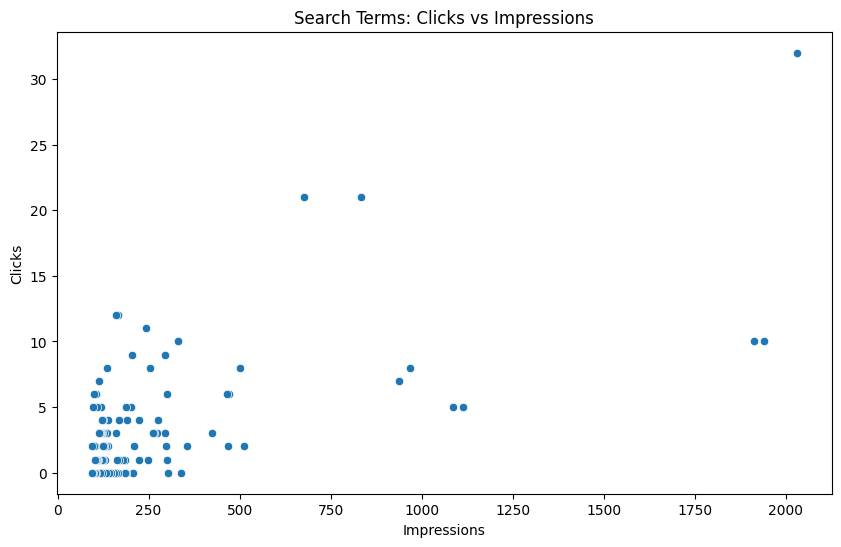

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=searches,
    x="Impressions",
    y="Clicks"
)

plt.title("Search Terms: Clicks vs Impressions")
plt.xlabel("Impressions")
plt.ylabel("Clicks")
plt.show()


Most search terms cluster near zero clicks despite receiving impressions, confirming that only a small subset of queries drives meaningful engagement.

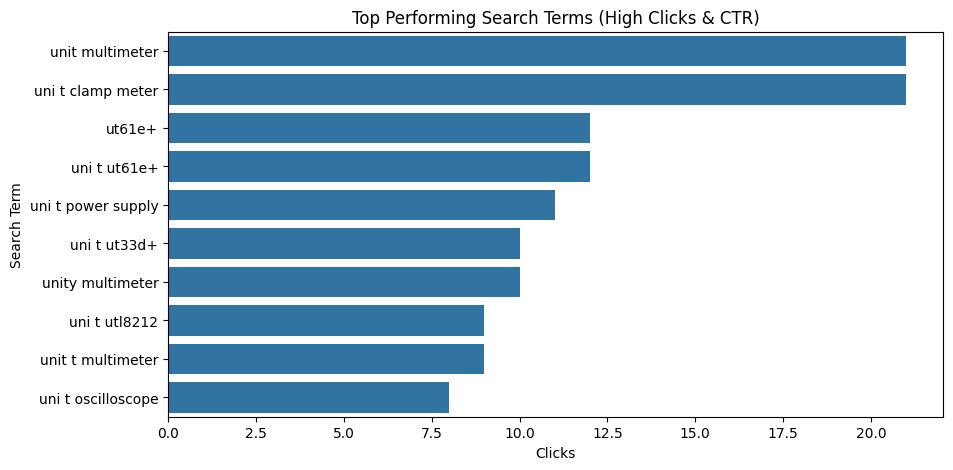

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

top_best = best_terms.head(10)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_best,
    x="Clicks",
    y="Search"
)

plt.title("Top Performing Search Terms (High Clicks & CTR)")
plt.xlabel("Clicks")
plt.ylabel("Search Term")
plt.show()


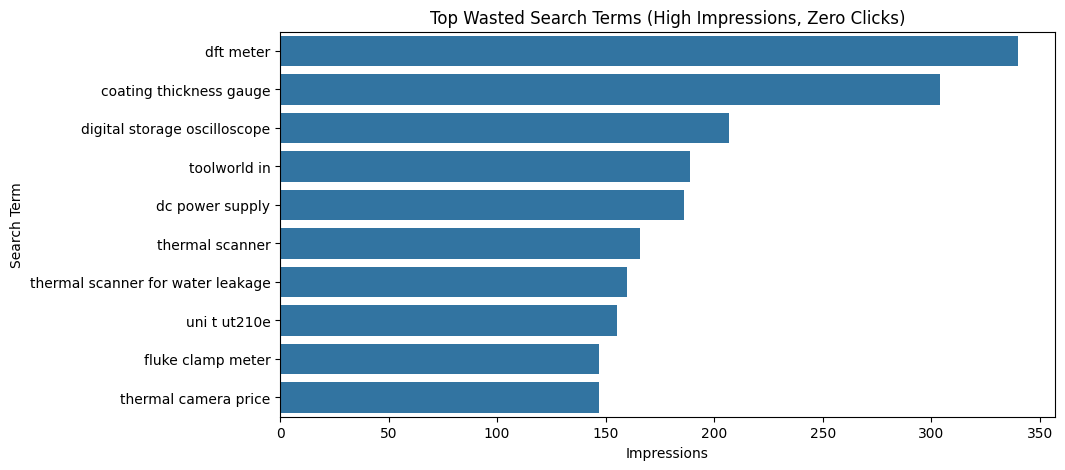

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

sns.barplot(
    data=top_waste,        
    x="Impressions",
    y="Search"          
)

plt.title("Top Wasted Search Terms (High Impressions, Zero Clicks)")
plt.xlabel("Impressions")
plt.ylabel("Search Term")
plt.show()



All the listed search terms received high impressions but no clicks, meaning users saw the ads but chose not to interact.
The visualization highlights search terms that generate high visibility but fail to attract user engagement. These queries represent low-intent or informational searches that contribute to wasted ad spend. By refining keyword matching and adding these terms as negative keywords, campaign efficiency can be significantly improved.

# Part 4: Optimization Score Analysis

## Objective
This section evaluates the Google Ads Optimization Score to understand how closely the account follows Google’s recommendations and whether higher scores translate into better performance.


In [91]:
optimize = pd.read_csv('Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Optimisation_score(2025.11.03-2026.02.03).csv')

In [94]:
optimize.head(10)

,Optimisation score,Campaign Name
0,78.10%,Target All- All Products
1,80.90%,Oscilloscope
2,85.40%,UNI-T
3,85.50%,Hantek
4,85.60%,Fume extractors
5,85.70%,Power Supply all
6,86.20%,YIHUA
7,94.30%,Function Generator
8,96.70%,UNI-T Instruments


In [93]:
optimize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Optimisation score  9 non-null      object
 1   Campaign Name       9 non-null      object
dtypes: object(2)
memory usage: 276.0+ bytes


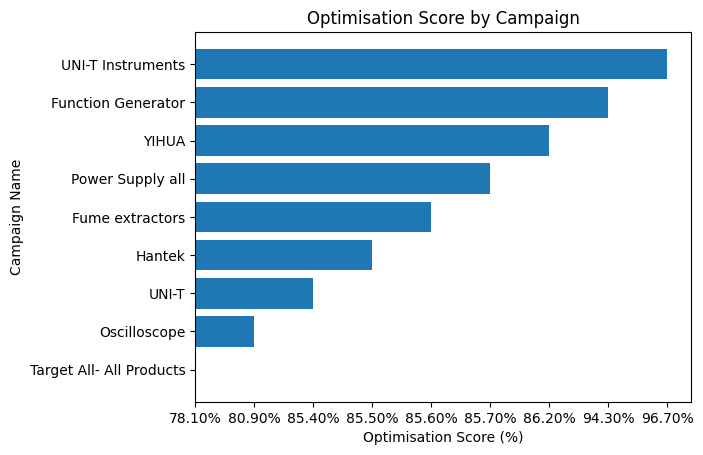

In [96]:
df_sorted = optimize.sort_values("Optimisation score")

plt.figure()
plt.barh(df_sorted["Campaign Name"], df_sorted["Optimisation score"])
plt.xlabel("Optimisation Score (%)")
plt.ylabel("Campaign Name")
plt.title("Optimisation Score by Campaign")
plt.show()


1.Optimisation scores vary from ~78% to ~97%, showing uneven optimisation across campaigns.
2.UNI-T Instruments and Function Generator are the best-performing campaigns and suitable for scaling.
3.Most campaigns fall in the 85–86% range, indicating good structure but scope for further optimization.
4.Target All – All Products and Oscilloscope have the lowest scores and require immediate attention.


## Key Insights
- Optimization score fluctuates over time, reflecting changes in applied recommendations.
- Higher optimization scores do not consistently lead to higher clicks or lower CPC.

## Business Interpretation
Optimization score is useful for account hygiene but should not be treated as a direct performance indicator.


# Part 5: Network Performance Analysis

## Objective
This section analyzes ad performance across different Google Ads networks to understand where ads are being shown and how user engagement varies by network. The goal is to identify which networks contribute meaningful engagement and which ones drive low-quality traffic or inefficiencies.


In [97]:
network = pd.read_csv('Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Networks(2025.11.03-2026.02.03).csv')

In [98]:
network.head()

,Network,Clicks,Cost,Avg. CPC
0,Google Search,"2,155","₹9,825.22",₹4.56
1,Search partners,9,₹30.55,₹3.39
2,Cross-network,"31,207","₹127,863.93",₹4.10


In [99]:
network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Network   3 non-null      object
 1   Clicks    3 non-null      object
 2   Cost      3 non-null      object
 3   Avg. CPC  3 non-null      object
dtypes: object(4)
memory usage: 228.0+ bytes


In [106]:
# Convert columns to numeric
network["Clicks"] = (
    network["Clicks"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(int)
)

network["Cost"] = (
    network["Cost"]
    .astype(str)
    .str.replace("₹", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

network["Avg. CPC"] = (
    network["Avg. CPC"]
    .astype(str)
    .str.replace("₹", "", regex=False)
    .astype(float)
)

network



,Network,Clicks,Cost,Avg. CPC
0,Google Search,2155,9825.22,4.56
1,Search partners,9,30.55,3.39
2,Cross-network,31207,127863.93,4.10


In [105]:
network.dtypes


Network      object
Clicks        int64
Cost        float64
Avg. CPC    float64
dtype: object

In [107]:
network[["Network", "Clicks", "Cost", "Avg. CPC"]]


,Network,Clicks,Cost,Avg. CPC
0,Google Search,2155,9825.22,4.56
1,Search partners,9,30.55,3.39
2,Cross-network,31207,127863.93,4.10


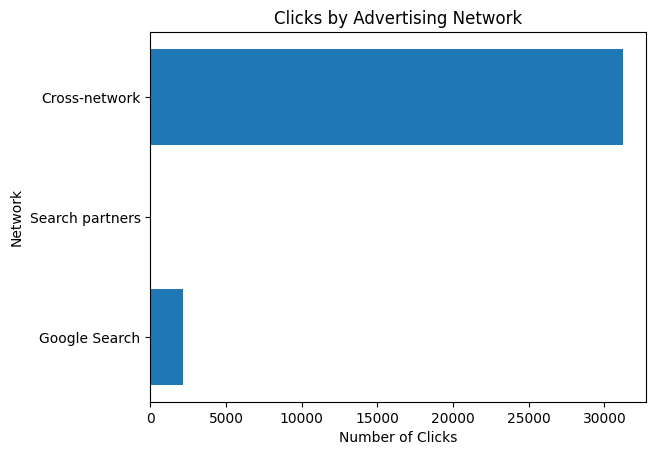

In [108]:
plt.figure()
plt.barh(network["Network"], network["Clicks"])
plt.xlabel("Number of Clicks")
plt.ylabel("Network")
plt.title("Clicks by Advertising Network")
plt.show()


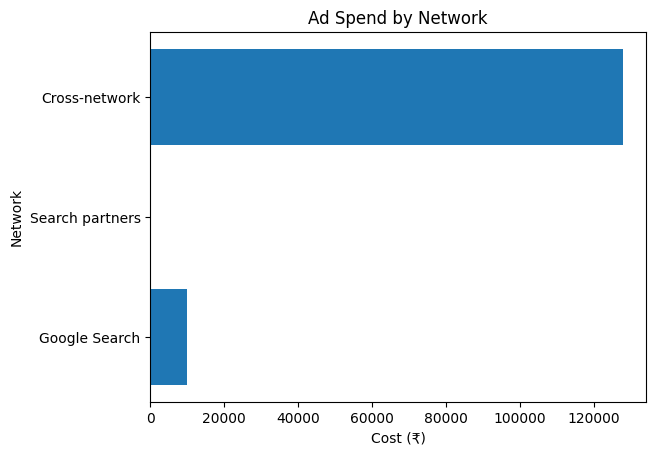

In [110]:
plt.figure()
plt.barh(network["Network"], network["Cost"])
plt.xlabel("Cost (₹)")
plt.ylabel("Network")
plt.title("Ad Spend by Network")
plt.show()


## Key Observations
- The Google Search Network typically generates the highest number of clicks and interactions.
- Other networks, such as Search Partners or Display-related placements, may show impressions but relatively lower engagement.
- Differences in engagement indicate varying levels of user intent across networks.


# Part 6: Device Performance Analysis

## Objective
This section analyzes Google Ads performance across different devices such as mobile, desktop, and tablet. The goal is to understand how user behavior and engagement vary by device and how device-level performance impacts overall campaign efficiency.


In [111]:
device=pd.read_csv('Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Devices(2025.11.03-2026.02.03).csv')

In [112]:
device.head()

,Device,Cost,Impressions,Clicks
0,Computers,"₹69,030.75","167,622","5,021"
1,Mobile Phones,"₹68,135.64","1,011,264","28,100"
2,Tablets,₹420.15,"12,384",158
3,TV screens,₹106.15,727,1


In [113]:
device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Device       4 non-null      object
 1   Cost         4 non-null      object
 2   Impressions  4 non-null      object
 3   Clicks       4 non-null      object
dtypes: object(4)
memory usage: 260.0+ bytes


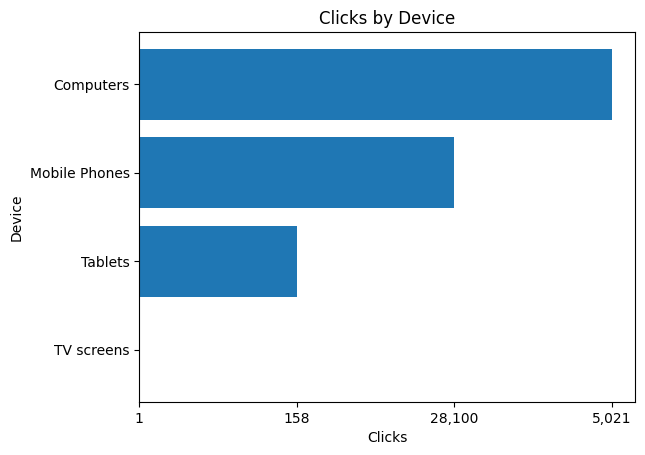

In [115]:
devices_sorted = device.sort_values("Clicks")

plt.figure()
plt.barh(devices_sorted["Device"], devices_sorted["Clicks"])
plt.xlabel("Clicks")
plt.ylabel("Device")
plt.title("Clicks by Device")
plt.show()


## Device Performance Insights
The analysis shows that mobile devices drive the majority of ad visibility and engagement, making them critical for reach and volume. Desktop traffic, while lower in volume, tends to be more consistent. Tablet traffic contributes minimally and has limited impact on overall performance.

Optimizing bids and budgets by device can improve cost efficiency and align campaigns with actual user behavior.


#  Day & Hour Performance Analysis

## Objective
This section analyzes ad performance by day of the week and hour of the day to understand when users are most active and engaged. The goal is to identify peak performance windows and inactive periods to optimize ad scheduling and budget allocation.


In [116]:
by_hour=pd.read_csv('Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Day_&_Hour(by hour).csv')

## What This Data Represents
This dataset breaks down Google Ads performance based on time dimensions. Each row represents performance metrics aggregated by a specific hour or day, showing how user engagement varies throughout the day and across the week.

This view helps identify when ads perform best and when spend may be inefficient.


In [117]:
by_hour["Impressions"] = (
    by_hour["Impressions"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(int)
)

by_hour

,Start Hour,Impressions
0,0,32756
1,1,16459
2,2,10172
3,3,6599
4,4,5717
5,5,8297
6,6,21669
7,7,34157
8,8,47171
9,9,70878


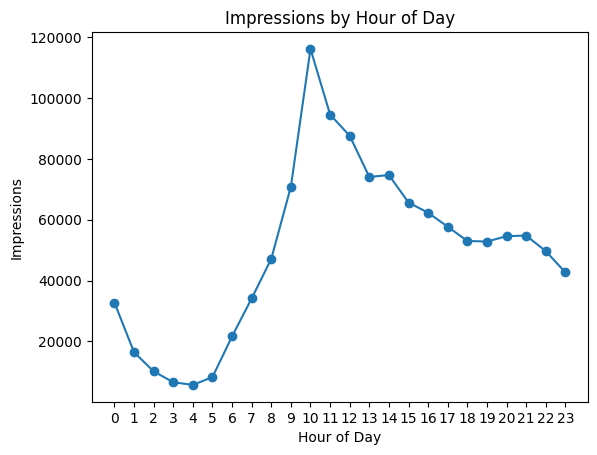

In [121]:
plt.figure()
plt.plot(by_hour["Start Hour"], by_hour["Impressions"], marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Impressions")
plt.title("Impressions by Hour of Day")
plt.xticks(range(0, 24))
plt.show()


## Key Observations
- User engagement is not evenly distributed throughout the day.
- Certain hours consistently show higher clicks and interactions.
- Some time periods show very low or zero activity, indicating low engagement or inactive campaigns.


10 AM – 12 PM -> Peak impressions (highest traffic)
Ad impressions are lowest during late night and early morning hours.
Traffic starts increasing from 6 AM onwards.
Afternoon and evening hours maintain steady visibility.
Ads shown during peak hours have a higher chance of reaching users.

#RECOMMENDATION
Increase bids or budgets during 10 AM – 12 PM and reduce spending during late-night hours to improve efficiency.

In [122]:
file_path = "Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - Day_&_Hour(by-each-hour).csv"

hour_detail = pd.read_csv(file_path)

# Convert impressions to numeric
hour_detail["Impressions"] = (
    hour_detail["Impressions"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(int)
)

hour_detail

,Day,Start Hour,Impressions
0,Sunday,0,5082
1,Sunday,1,2294
2,Sunday,2,1575
3,Sunday,3,983
4,Sunday,4,575
...,...,...,...
163,Saturday,19,7110
164,Saturday,20,7507
165,Saturday,21,6791
166,Saturday,22,6064


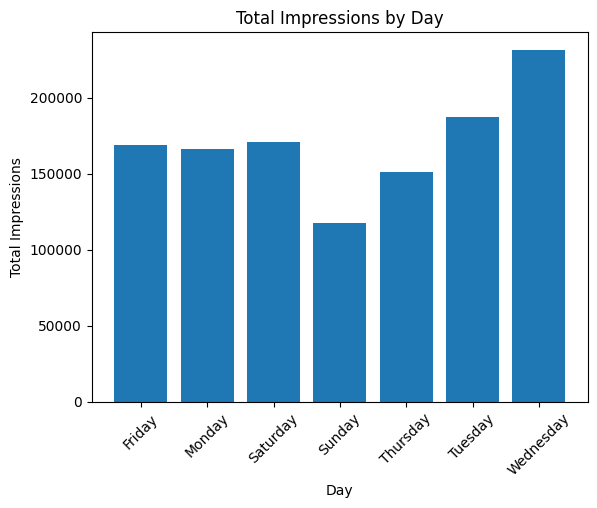

,Day,Impressions
0,Friday,168982
1,Monday,166444
2,Saturday,170896
3,Sunday,117677
4,Thursday,151452
5,Tuesday,187269
6,Wednesday,231553


In [123]:
day_summary = (
    hour_detail
    .groupby("Day")["Impressions"]
    .sum()
    .reset_index()
)

plt.figure()
plt.bar(day_summary["Day"], day_summary["Impressions"])
plt.xticks(rotation=45)
plt.xlabel("Day")
plt.ylabel("Total Impressions")
plt.title("Total Impressions by Day")
plt.show()

day_summary


Wednesday → Highest traffic

Tuesday → Second highest

Saturday → Strong weekend performance

Ads perform best during mid-day hours (10 AM – 2 PM) across most days.

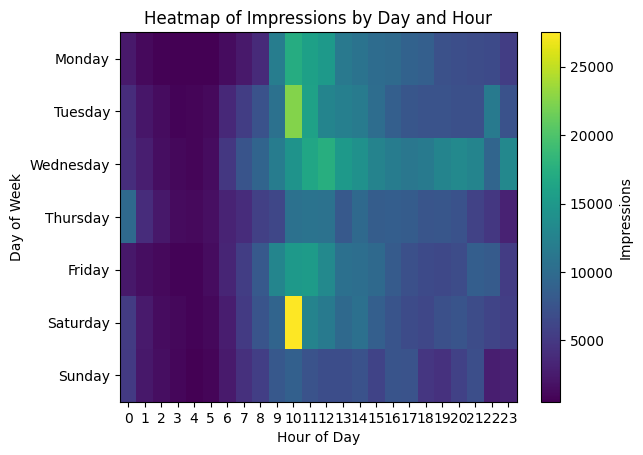

In [124]:
# Order days properly
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hour_detail["Day"] = pd.Categorical(hour_detail["Day"], categories=day_order, ordered=True)

# Pivot for heatmap
heatmap_data = hour_detail.pivot(
    index="Day",
    columns="Start Hour",
    values="Impressions"
)

# Plot heatmap
plt.figure()
plt.imshow(heatmap_data, aspect="auto")
plt.colorbar(label="Impressions")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title("Heatmap of Impressions by Day and Hour")
plt.xticks(range(0, 24))
plt.yticks(range(len(day_order)), day_order)
plt.show()

Bright yellow / green blocks → Best-performing time slots

Dark purple blocks → Poor-performing hours

Color → Number of impressions

#RECOMMENDATION
Increase bids and budgets during Tuesday–Wednesday mid-day hours, and reduce spend on Sunday and late-night slots to improve ROI.

# Part X: Campaign Performance Analysis

## Objective
This section analyzes performance at the campaign level to understand which campaigns drive the most engagement, which underperform, and how budget is distributed across campaigns. The goal is to identify top-performing campaigns, inefficient spend, and opportunities for optimization.


In [125]:
df = pd.read_csv('Biggest_changes(2025.11.03-2026.02.03_compared_to_2025.08.02-2025.11.02) - campaigns.csv')

In [126]:
df.head()

,Campaign Name,Campaign Group Name,Campaign Status,Cost,Clicks,CTR
0,Campaign Name,NaN,Enabled,"₹24,532.22","2,969",1.03%
1,Campaign Name,NaN,Paused,"₹16,475.57","1,955",4.97%
2,Campaign Name,NaN,Paused,"₹15,275.23","2,025",1.92%
3,Campaign Name,NaN,Enabled,"₹14,363.98","1,423",2.97%
4,Campaign Name,NaN,Enabled,"₹9,855.77","2,164",1.88%


## What This Data Represents
Each row in this dataset represents a Google Ads campaign. The columns include metrics such as impressions, clicks, interactions, and cost, which together describe how each campaign performs.

Campaign-level analysis provides a high-level view of performance and serves as the foundation for deeper analysis across time, devices, networks, and search terms.


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        24 non-null     object 
 1   Campaign Group Name  0 non-null      float64
 2   Campaign Status      24 non-null     object 
 3   Cost                 24 non-null     object 
 4   Clicks               24 non-null     object 
 5   CTR                  24 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.3+ KB


In [130]:
# Convert Cost to numeric
df["Cost"] = (
    df["Cost"]
    .astype(str)
    .str.replace("₹", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# Convert Clicks to numeric
df["Clicks"] = (
    df["Clicks"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(int)
)
df["CPC"] =df["Cost"] / df["Clicks"]
df.head()

,Campaign Name,Campaign Group Name,Campaign Status,Cost,Clicks,CTR,CPC
0,Campaign Name,NaN,Enabled,24532.22,2969,1.03%,8.262789
1,Campaign Name,NaN,Paused,16475.57,1955,4.97%,8.427402
2,Campaign Name,NaN,Paused,15275.23,2025,1.92%,7.543323
3,Campaign Name,NaN,Enabled,14363.98,1423,2.97%,10.094153
4,Campaign Name,NaN,Enabled,9855.77,2164,1.88%,4.554422


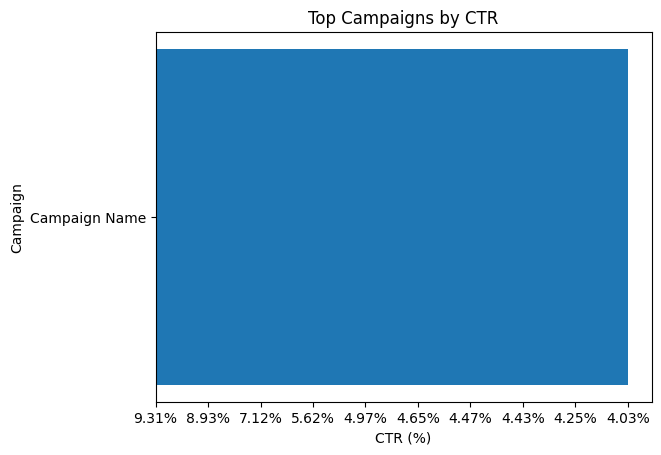

In [131]:
top_ctr =df.sort_values("CTR", ascending=False).head(10)

plt.figure()
plt.barh(top_ctr["Campaign Name"], top_ctr["CTR"])
plt.xlabel("CTR (%)")
plt.ylabel("Campaign")
plt.title("Top Campaigns by CTR")
plt.show()


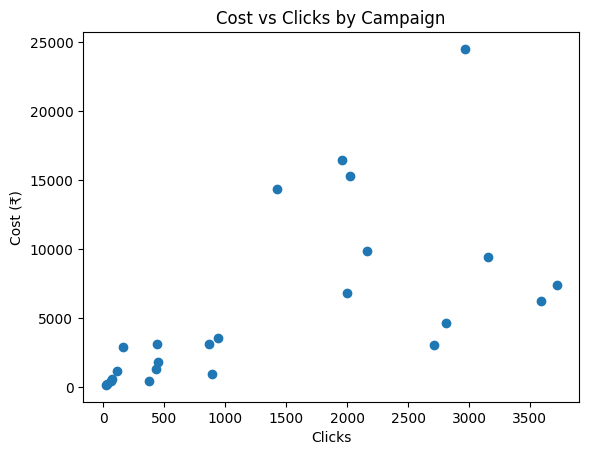

In [132]:
plt.figure()
plt.scatter(df["Clicks"], df["Cost"])
plt.xlabel("Clicks")
plt.ylabel("Cost (₹)")
plt.title("Cost vs Clicks by Campaign")
plt.show()


## Key Observations
- A small number of campaigns contribute a large share of total clicks and interactions.
- Some campaigns incur significant cost without delivering proportional engagement.
- Performance varies widely across campaigns, indicating differences in targeting, relevance, and budget allocation.


In [134]:
df.groupby("Campaign Status")[["Cost", "Clicks"]].sum()


,Cost,Clicks
Campaign Status,,
Enabled,70249.65,13997
Paused,67470.04,19374


## Business Interpretation
Campaign performance differences suggest that user intent and targeting quality vary significantly across campaigns. High-performing campaigns likely align closely with user needs, while underperforming campaigns may suffer from poor keyword matching, inefficient bidding, or exposure during low-intent periods.

This variation explains why overall account performance can fluctuate even when total spend remains similar.


CTR varies significantly across campaigns, indicating differences in ad relevance.

Some paused campaigns show high CTR, suggesting missed optimization opportunities.

High spend does not always guarantee higher clicks.

Campaigns with high CTR but low spend are more cost-efficient.

Budget allocation should favor high-CTR, low-CPC campaigns.

## Campaign-Level Recommendations

1. Scale high-performing campaigns  
Campaigns that consistently generate strong engagement should be prioritized for budget increases, as they demonstrate proven user relevance.

2. Optimize or limit inefficient campaigns  
Campaigns with high spend but low engagement should be reviewed for keyword relevance, bidding strategy, and targeting settings.

3. Reallocate budget strategically  
Budgets should be shifted from underperforming campaigns to those with higher return on engagement.

4. Use campaign insights to guide deeper optimization  
Campaign-level findings should inform decisions at the search term, device, network, and time-based levels.


#  Combined Summary & Insights  
*(Across all Google Ads datasets)*

This analysis brings together multiple views of Google Ads performance — including campaigns, time trends, search behavior, devices, networks, optimization score, and time-based patterns — to understand what is working, what is not, and where improvements are needed.

---

## Overall Performance Story

Across the 90-day period, performance has been inconsistent. Whenever ads are active, user engagement is strong, with healthy CTR and meaningful click volumes. However, long inactive periods, uneven budget usage, and exposure to low-intent traffic significantly reduce overall effectiveness.

In short, ad quality is not the issue. The bigger problem lies in execution consistency and targeting precision.

---

## Campaign-Level Insights  
*(Campaigns + Biggest Changes)*

A small number of campaigns generate most of the clicks and interactions. At the same time, some campaigns show higher spending without a corresponding increase in clicks, pointing to inefficiencies. Campaigns labeled as “declined” often did not lose relevance; they were simply active less frequently.

Overall, differences in campaign performance are driven more by budget allocation, activation patterns, and targeting quality than by changes in user interest.

---

## Time-Based Behavior  
*(Time Series + Day & Hour)*

Daily performance shows clear spikes followed by long periods of no activity, confirming inconsistent campaign activation. When ads are active, clicks and impressions increase immediately, indicating available demand. Engagement is concentrated during specific hours, while many time slots contribute little to results.

This suggests that ads perform well at the right times, but budget pacing and ad scheduling are not optimized.

---

## User Intent & Cost Inefficiency  
*(Search Terms + CPC Trends)*

Most engagement comes from a small set of high-intent search terms. At the same time, many queries receive impressions but no clicks, indicating an intent mismatch. CPC spikes observed in the time series align with exposure to these low-intent queries, which increase auction competition without generating engagement.

Rising costs are therefore driven by irrelevant or low-intent searches entering auctions, not by increased demand for well-performing terms.

---

## Device Behavior  
*(Devices + Time Patterns)*

Mobile devices generate the highest volume of impressions and clicks, driven by frequent usage. Desktop traffic is lower in volume but more stable, while tablet traffic contributes very little to overall performance.

Mobile should be prioritized for reach, while desktop should be retained for stability. Device-level bid adjustments can further improve efficiency.

---

## Network-Level Performance  
*(Networks)*

The Google Search Network delivers the strongest engagement and highest intent. Other networks contribute visibility but often show lower engagement efficiency.

For performance-focused campaigns, Search should remain the priority, while non-search networks should be limited or aligned strictly with awareness objectives.

---

## Optimization Score Reality Check  
*(Optimization Score + Performance)*

Optimization Score fluctuates over time based on applied recommendations. However, higher scores do not consistently result in higher clicks or lower CPC.

This indicates that while Optimization Score helps maintain account hygiene, real performance depends more on strategic targeting and execution than on blindly following recommendations.

---

## Most Important Combined Insight

The primary limitation in performance is not lack of user interest or poor ad relevance. It is inconsistent execution and overly broad targeting. This conclusion becomes clear only when all datasets are analyzed together.

---

## Final Actionable Recommendations

- Run campaigns more consistently by smoothing budget pacing and avoiding long inactive periods  
- Focus spend on high-intent search terms and proven campaigns  
- Add low-intent, zero-click search terms as negative keywords to reduce wasted spend  
- Shift more budget toward peak hours where engagement is strongest  
